# Data Exploration for the Sepsis Dataset

In [34]:
import os
import sys
import random
import pandas as pd
import numpy as np
from scipy.linalg import toeplitz
from copy import copy
import math
# import hypertools as hyp
import matplotlib.pyplot as plt
from matplotlib.cm import viridis
import seaborn as sns

# Geniuses that worked on hypertools did not update certain package and thus it produces warnings (they break jupyter lab)
import warnings
warnings.filterwarnings("ignore")

# Comment out if you don't want to see all of.the values being printed (i.e. default)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

current_dir = os.getcwd()
# utils_path = os.path.join(current_dir, '..', 'utils')
utils_path = os.path.join(current_dir, '../')
utils_abs_path = os.path.abspath(utils_path)
if utils_abs_path not in sys.path:
    sys.path.append(utils_abs_path)

import utils.get_data as get_data
# from impute_methods import *
from utils.impute_methods import *

DATA_PATH = get_data.get_dataset_abspath()

training_setA_path = DATA_PATH + 'training_setA'
training_setB_path = DATA_PATH + 'training_setB'

figures_path = "figures/"

In [35]:
num_files=100
df = get_data.get_dataset_as_df(files=num_files)
files, _ = get_data.get_dataset_as_np(files=num_files, concat_files=False)

data = df.values
column_names = df.columns.tolist()

Loading dataset...


100%|██████████| 100/100 [00:00<00:00, 1595.64it/s]


Done.
Loading dataset...


100%|██████████| 100/100 [00:00<00:00, 2591.41it/s]

Done.


In [36]:
print("Number of files: " + str(len(files)))
print("Number of columns: " + str(len(files[0][0])))
print("Length of file 1: " + str(len(files[0])))

Number of files: 100
Number of columns: 41
Length of file 1: 55


# Exploring NaN value counts

In [37]:
def sort_columns_by_data(column_names, data):

    # Sort the combined list based on the values
    sorted_ = sorted(list(zip(column_names, data)), key=lambda x: x[1])

    return [item[0] for item in sorted_], np.array([item[1] for item in sorted_])
def count_nan(arr):
    return np.sum(np.isnan(arr), axis=0)

In [38]:
# Count the number of NaN values in each column
nan_counts = count_nan(data)

In [39]:
print(f"Number of NaN values for each column of the dataset ({num_files} files)")

# Order the column names based on the number of NaN values in each
sorted_column_names, sorted_nan_counts = sort_columns_by_data(column_names, nan_counts)
sorted_nan_percentages = np.round(sorted_nan_counts/data.shape[0] * 100, 2)

# Print the NaN counts of each column
for index, (nan_count, column_name)  in enumerate(zip(sorted_nan_counts, sorted_column_names)):
    print(f"{column_name}: {nan_count}/{data.shape[0]} ({sorted_nan_percentages[index]}%)")

Number of NaN values for each column of the dataset (100 files)
Age: 0/3785 (0.0%)
Gender: 0/3785 (0.0%)
HospAdmTime: 0/3785 (0.0%)
ICULOS: 0/3785 (0.0%)
SepsisLabel: 0/3785 (0.0%)
HR: 278/3785 (7.34%)
MAP: 391/3785 (10.33%)
Resp: 471/3785 (12.44%)
O2Sat: 482/3785 (12.73%)
SBP: 655/3785 (17.31%)
Unit1: 2028/3785 (53.58%)
Unit2: 2028/3785 (53.58%)
DBP: 2403/3785 (63.49%)
Temp: 2596/3785 (68.59%)
Hct: 3365/3785 (88.9%)
FiO2: 3401/3785 (89.85%)
Glucose: 3421/3785 (90.38%)
Potassium: 3422/3785 (90.41%)
Hgb: 3476/3785 (91.84%)
pH: 3481/3785 (91.97%)
Chloride: 3483/3785 (92.02%)
HCO3: 3490/3785 (92.21%)
BUN: 3491/3785 (92.23%)
Magnesium: 3503/3785 (92.55%)
BaseExcess: 3511/3785 (92.76%)
WBC: 3511/3785 (92.76%)
Platelets: 3538/3785 (93.47%)
Creatinine: 3542/3785 (93.58%)
PaCO2: 3564/3785 (94.16%)
Phosphate: 3576/3785 (94.48%)
Calcium: 3578/3785 (94.53%)
PTT: 3599/3785 (95.09%)
Lactate: 3669/3785 (96.94%)
SaO2: 3678/3785 (97.17%)
AST: 3715/3785 (98.15%)
Alkalinephos: 3717/3785 (98.2%)
Bilirubi

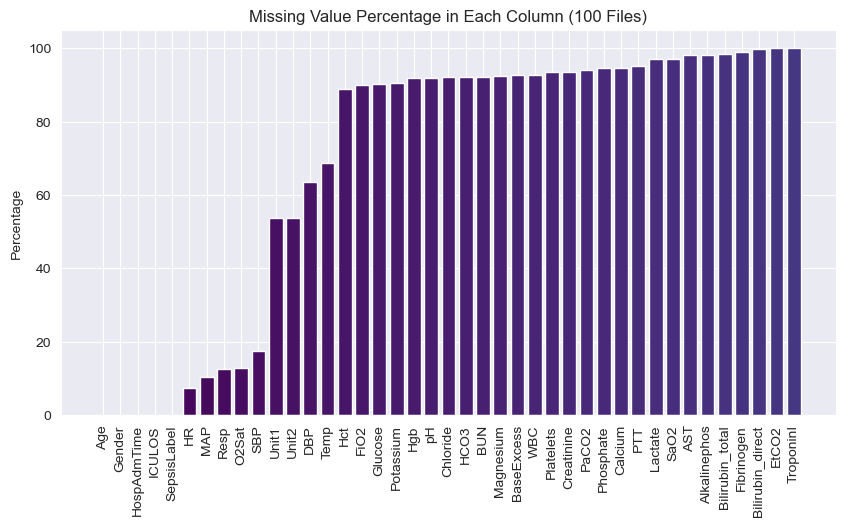

In [40]:
# Order the column names based on the number of NaN values in each
sorted_column_names, sorted_nan_counts = sort_columns_by_data(column_names, nan_counts)
sorted_nan_percentages = np.round(sorted_nan_counts/data.shape[0] * 100, 2)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title(f"Missing Value Percentage in Each Column ({num_files} Files)")
ax.set_ylabel("Percentage")
ax.bar(sorted_column_names, sorted_nan_percentages, color=viridis.colors)
ax.tick_params(axis='x', labelrotation=90)
plt.plot()
plt.savefig(figures_path + "NaN counts.png", bbox_inches = "tight");

# Data Imputation

Due to the high number of missing values in the dataset, it is necessary to perform *data imputation*. This involves estimating numerical values that can replace the missing values while maintaining the distriubition of each feature as well as the colinearities between features.

In [41]:
# Let us look at a random specific patient file

# Change to empty strign to get random file
specific_filename = "p001146.psv"

# From training set A
file_path = random.choice(os.listdir(training_setA_path)) if specific_filename == "" else specific_filename
file_data = pd.read_csv(training_setA_path + "/" + file_path, sep='|')
print(file_path)
print(file_data['HR'])

p001146.psv
0     88.0
1     76.0
2     72.0
3     81.0
4      NaN
5     94.0
6     80.0
7     88.0
8     78.0
9     80.0
10    86.0
11    86.0
12     NaN
13     NaN
14    75.0
15    69.0
16     NaN
17    85.0
18    83.0
19    84.0
20    73.0
21    73.0
22     NaN
23    97.0
Name: HR, dtype: float64


In [42]:
# This linearly interpolates the Heart Rate values which could be sufficient
imputed_data = impute_linear_interpolation(file_data, 'HR')

print(imputed_data['HR'])

0     88.000000
1     76.000000
2     72.000000
3     81.000000
4     87.500000
5     94.000000
6     80.000000
7     88.000000
8     78.000000
9     80.000000
10    86.000000
11    86.000000
12    82.333333
13    78.666667
14    75.000000
15    69.000000
16    77.000000
17    85.000000
18    83.000000
19    84.000000
20    73.000000
21    73.000000
22    85.000000
23    97.000000
Name: HR, dtype: float64


In [43]:
df["Resp"]

0       13.5
1       12.0
2       12.0
3       12.0
4       12.5
        ... 
3780     NaN
3781    16.0
3782    14.0
3783     NaN
3784    16.0
Name: Resp, Length: 3785, dtype: float64

In [44]:
imputed_data = impute_forward_fill_last_recorded(df, "Resp")
imputed_data["Resp"]

0       13.5
1       12.0
2       12.0
3       12.0
4       12.5
        ... 
3780    15.0
3781    16.0
3782    14.0
3783    14.0
3784    16.0
Name: Resp, Length: 3785, dtype: float64

# Data Imputation of the dataset
The imputation scheme to be followed is to forward fill values from the last recorded value. If there is no previous value, replace with the feature mean for that patient, if there are no values at all for a patient, replace with the global mean.

In [45]:
imputed_dataset = impute_all(files, column_names)

In [46]:
imputed_nan_counts = count_nan(imputed_dataset)

In [47]:
print(f"Number of NaN values for each column of the dataset ({num_files} files)")

# Order the column names based on the number of NaN values in each
sorted_column_names, sorted_nan_counts = sort_columns_by_data(column_names, imputed_nan_counts)
sorted_nan_percentages = np.round(sorted_nan_counts/data.shape[0] * 100, 2)

# Print the NaN counts of each column
for index, (nan_count, column_name)  in enumerate(zip(sorted_nan_counts, sorted_column_names)):
    print(f"{column_name}: {nan_count}/{data.shape[0]} ({sorted_nan_percentages[index]}%)")

Number of NaN values for each column of the dataset (100 files)
HR: 0/3785 (0.0%)
O2Sat: 0/3785 (0.0%)
Temp: 0/3785 (0.0%)
SBP: 0/3785 (0.0%)
MAP: 0/3785 (0.0%)
DBP: 0/3785 (0.0%)
Resp: 0/3785 (0.0%)
BaseExcess: 0/3785 (0.0%)
HCO3: 0/3785 (0.0%)
FiO2: 0/3785 (0.0%)
pH: 0/3785 (0.0%)
PaCO2: 0/3785 (0.0%)
SaO2: 0/3785 (0.0%)
AST: 0/3785 (0.0%)
BUN: 0/3785 (0.0%)
Alkalinephos: 0/3785 (0.0%)
Calcium: 0/3785 (0.0%)
Chloride: 0/3785 (0.0%)
Creatinine: 0/3785 (0.0%)
Bilirubin_direct: 0/3785 (0.0%)
Glucose: 0/3785 (0.0%)
Lactate: 0/3785 (0.0%)
Magnesium: 0/3785 (0.0%)
Phosphate: 0/3785 (0.0%)
Potassium: 0/3785 (0.0%)
Bilirubin_total: 0/3785 (0.0%)
Hct: 0/3785 (0.0%)
Hgb: 0/3785 (0.0%)
PTT: 0/3785 (0.0%)
WBC: 0/3785 (0.0%)
Fibrinogen: 0/3785 (0.0%)
Platelets: 0/3785 (0.0%)
Age: 0/3785 (0.0%)
Gender: 0/3785 (0.0%)
Unit1: 0/3785 (0.0%)
Unit2: 0/3785 (0.0%)
HospAdmTime: 0/3785 (0.0%)
ICULOS: 0/3785 (0.0%)
SepsisLabel: 0/3785 (0.0%)
EtCO2: 3785/3785 (100.0%)
TroponinI: 3785/3785 (100.0%)


## Data Exploration

### Data imbalance

In [48]:
# Obtain the ratio SepsisLabel=0:SepsisLabel=1
label_counts = df["SepsisLabel"].value_counts()
zero_count = label_counts[0.0] 
one_count = label_counts[1.0]

divisor = math.gcd(zero_count, one_count)

ratio = f"{int(zero_count/divisor)}:{int(one_count/divisor)}"

print(f"Ratio SepsisLabel=0:SepsisLabel=1 is {ratio}")

Ratio SepsisLabel=0:SepsisLabel=1 is 746:11


# Informative Features

In [49]:
label_counts = []
for i, feature_name in enumerate(df):
    if feature_name == "SepsisLabel":
        continue
    feature_data = df[[feature_name, "SepsisLabel"]].groupby('SepsisLabel').count()
    if feature_data.iloc[:, 0].sum() != df.shape[0]:
        label_counts.append(feature_data)

#
label_counts = sorted(label_counts, key=lambda x: x.iloc[:, 0].sum(), reverse=True)
label_counts_percentages = [x / x.sum() * 100 for x in label_counts]

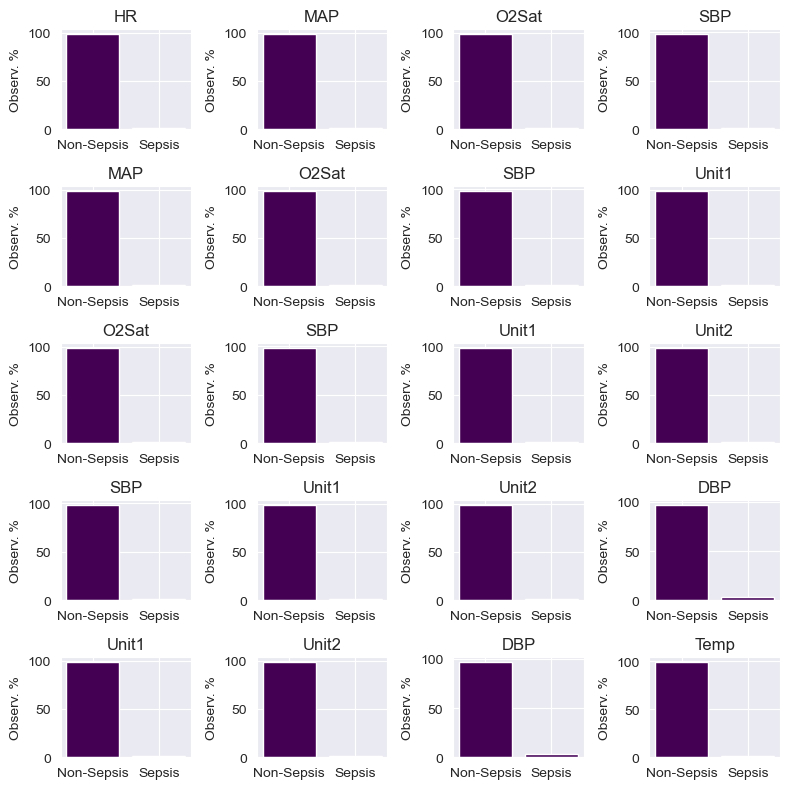

In [50]:
num_features = 17

ncols = 4
nrows = int(np.ceil(num_features/ncols))

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 8))

# Iterate through each feature and plot its count of 1s and 0s
for row_index in range(nrows):
    for col_index in range(ncols):
        ax = axs[row_index][col_index]
        data = label_counts_percentages[row_index + col_index]

        colours = viridis.colors
        for i, (label, value) in enumerate(data.iterrows()):
            label = "Non-Sepsis" if label==0 else "Sepsis"
            ax.bar(label, value.iloc[0], color=colours[i % len(colours)])

        ax.set_yticks([0, 50, 100])
        ax.set_ylabel("Observ. %")
        ax.set_title(data.columns[0])

plt.tight_layout()
plt.savefig(figures_path + "Feature Label Counts.png", bbox_inches = "tight");
plt.show();

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3785 entries, 0 to 3784
Data columns (total 41 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HR                3507 non-null   float64
 1   O2Sat             3303 non-null   float64
 2   Temp              1189 non-null   float64
 3   SBP               3130 non-null   float64
 4   MAP               3394 non-null   float64
 5   DBP               1382 non-null   float64
 6   Resp              3785 non-null   float64
 7   EtCO2             0 non-null      float64
 8   BaseExcess        274 non-null    float64
 9   HCO3              295 non-null    float64
 10  FiO2              384 non-null    float64
 11  pH                304 non-null    float64
 12  PaCO2             221 non-null    float64
 13  SaO2              107 non-null    float64
 14  AST               70 non-null     float64
 15  BUN               294 non-null    float64
 16  Alkalinephos      68 non-null     float64


array([[<Axes: title={'center': 'HR'}>,
        <Axes: title={'center': 'O2Sat'}>,
        <Axes: title={'center': 'Temp'}>,
        <Axes: title={'center': 'SBP'}>, <Axes: title={'center': 'MAP'}>,
        <Axes: title={'center': 'DBP'}>],
       [<Axes: title={'center': 'Resp'}>,
        <Axes: title={'center': 'EtCO2'}>,
        <Axes: title={'center': 'BaseExcess'}>,
        <Axes: title={'center': 'HCO3'}>,
        <Axes: title={'center': 'FiO2'}>, <Axes: title={'center': 'pH'}>],
       [<Axes: title={'center': 'PaCO2'}>,
        <Axes: title={'center': 'SaO2'}>,
        <Axes: title={'center': 'AST'}>, <Axes: title={'center': 'BUN'}>,
        <Axes: title={'center': 'Alkalinephos'}>,
        <Axes: title={'center': 'Calcium'}>],
       [<Axes: title={'center': 'Chloride'}>,
        <Axes: title={'center': 'Creatinine'}>,
        <Axes: title={'center': 'Bilirubin_direct'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'Lactate'}>,
        <Axes: t

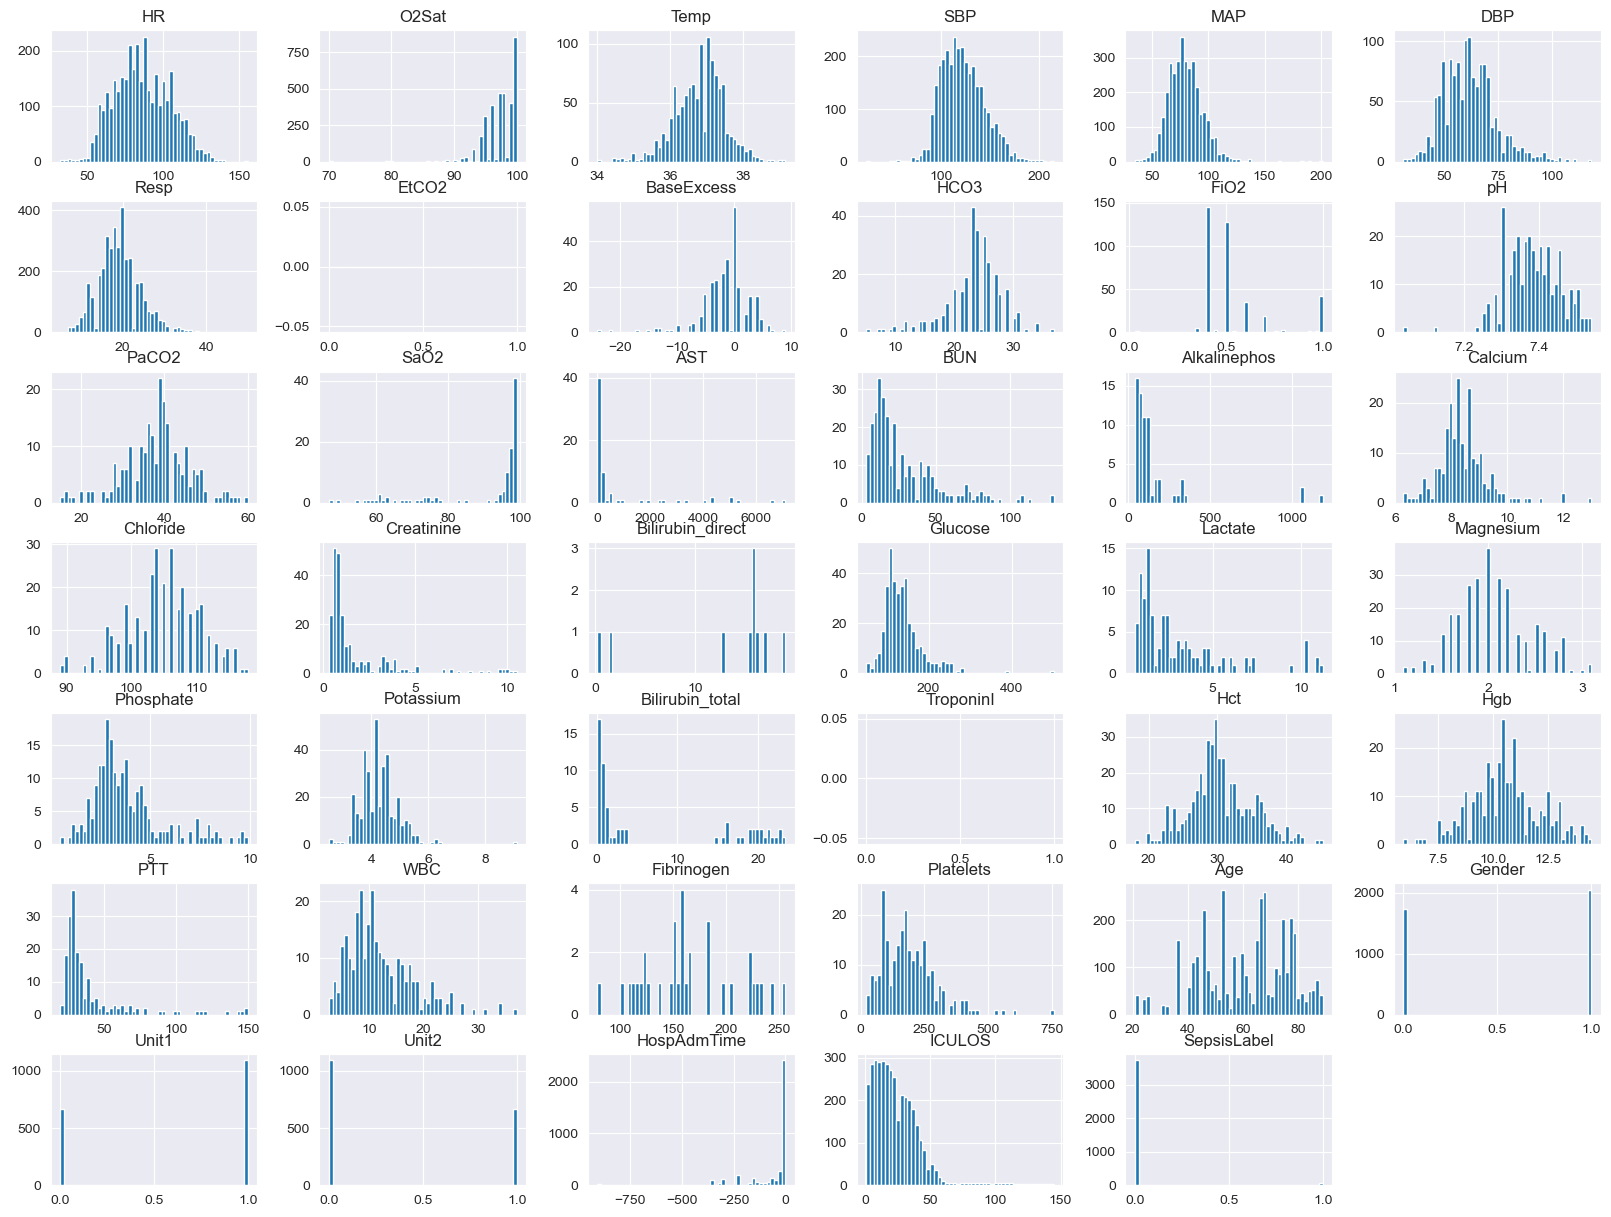

In [52]:
# Histograms
df.hist(figsize=(20,15), bins=50)
plt.show()

<Figure size 2000x1000 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Matrix')

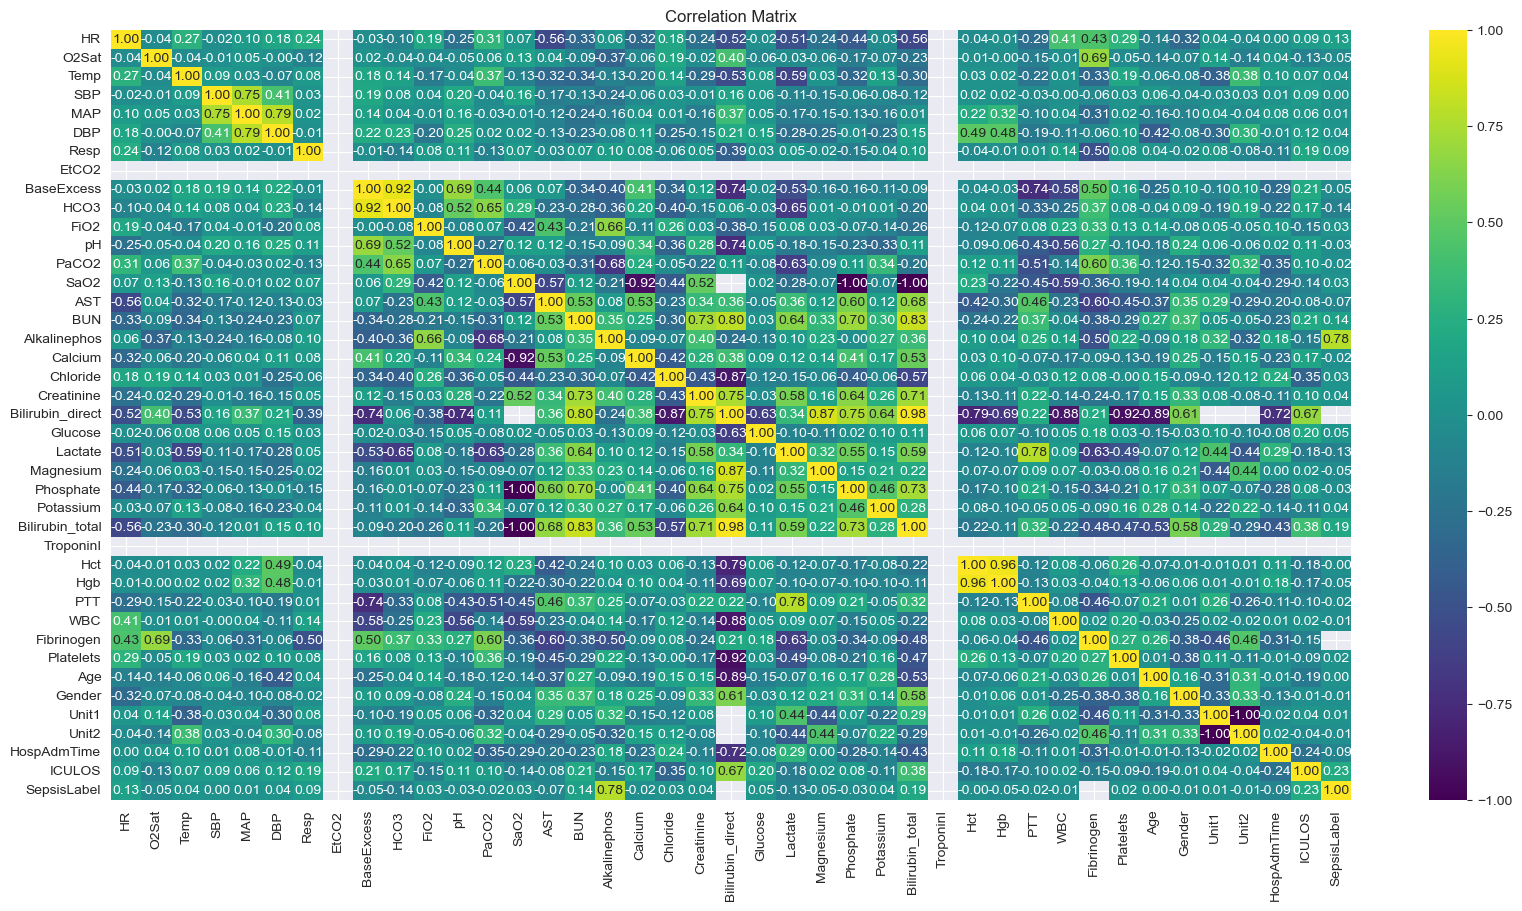

In [53]:
# Compute correlation matrix
correlation_matrix = df.corr()

# Visualize the correlation matrix 
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

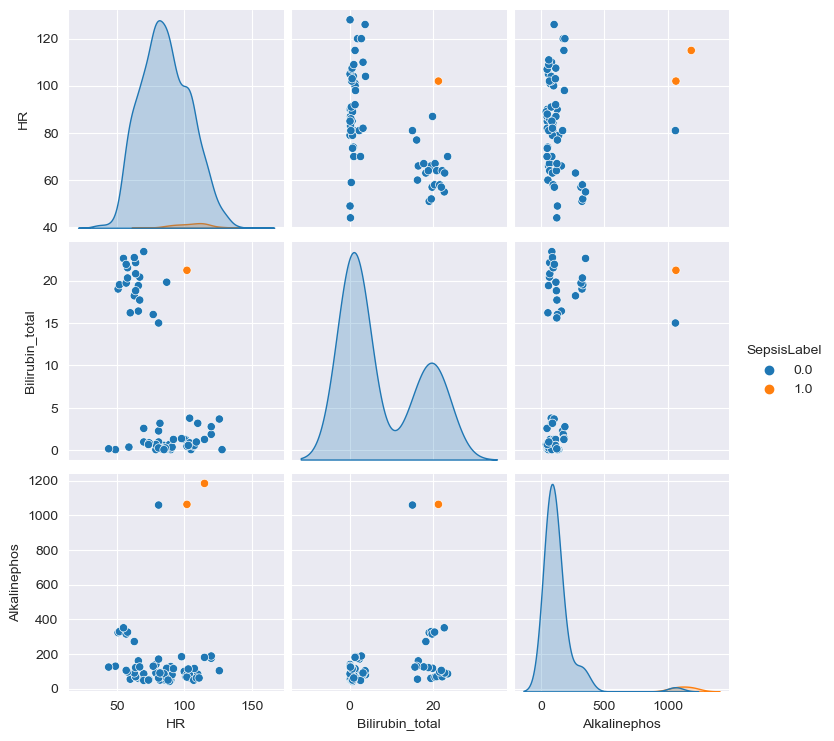

In [62]:
# Pair plots with SepsisLabel 
sns.pairplot(df[['HR', 'SepsisLabel','Bilirubin_total','Alkalinephos']], hue='SepsisLabel', diag_kind='kde')
plt.show()

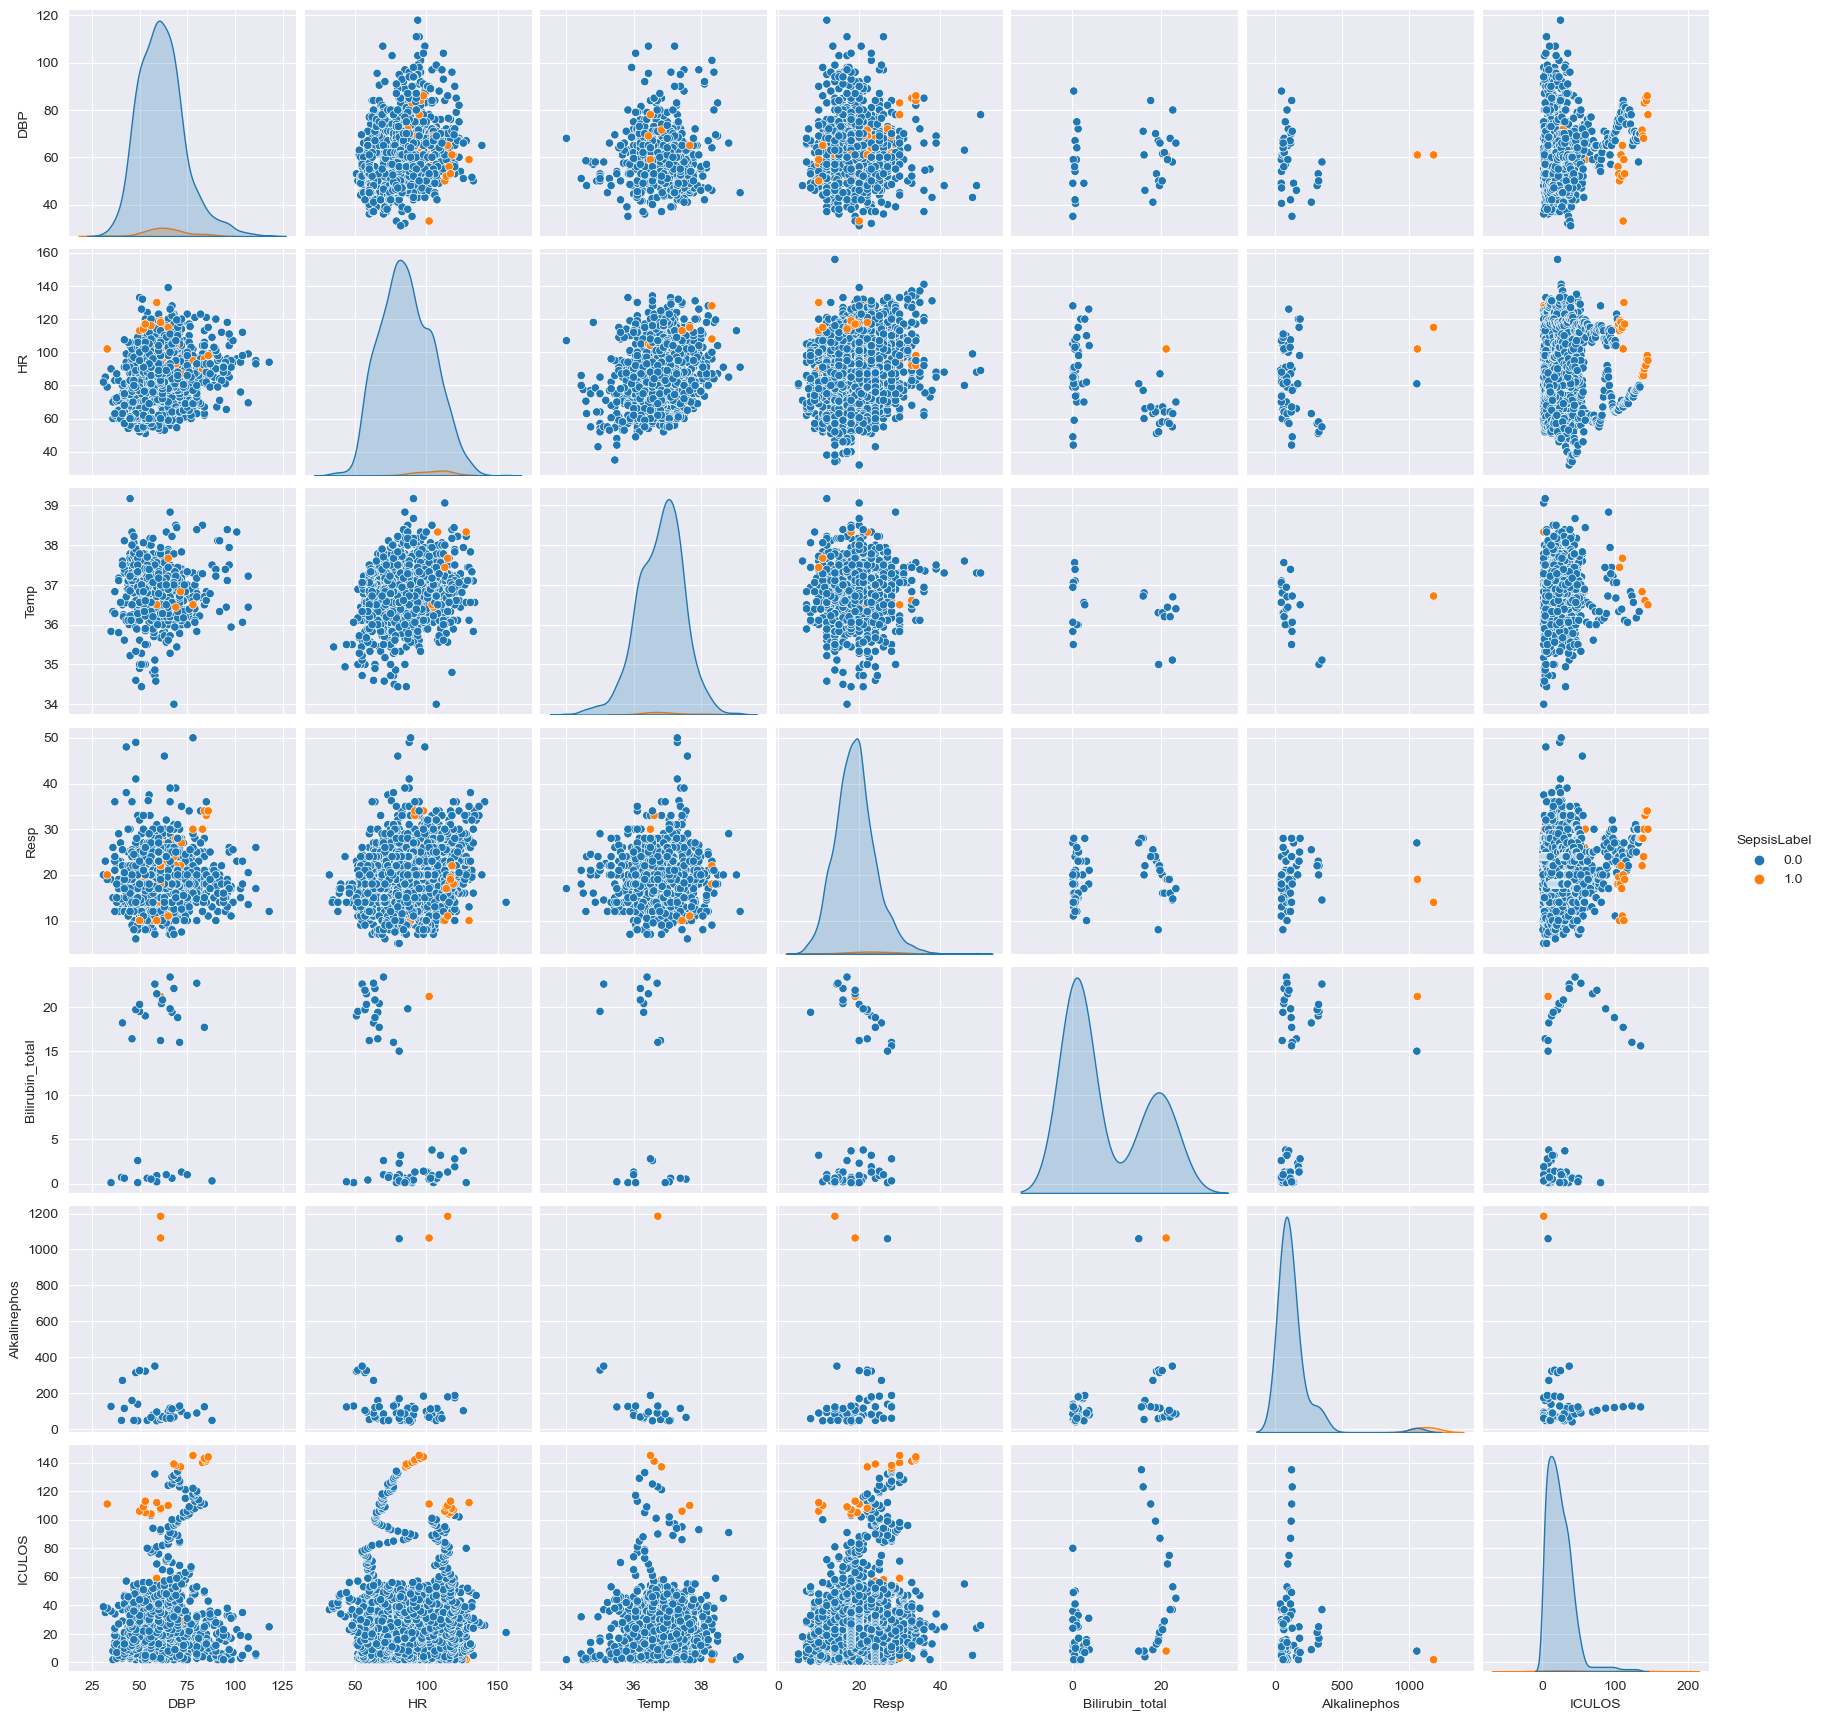

In [63]:
# More features are added based on the result of earlier Eda
sns.pairplot(df[['DBP','HR', 'Temp', 'Resp', 'SepsisLabel','Bilirubin_total','Alkalinephos','ICULOS']], hue='SepsisLabel', diag_kind='kde')

plt.show()